## Walmart Data - Analysis

In [73]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

dataset = pd.read_csv("D:\DataScience\Assignment-2_optional\Walmart_Store_sales.csv")
print("Number of rows : {}".format(dataset.shape[0]))
dataset.head()

Number of rows : 6435


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [74]:
from plotly.subplots import make_subplots

num_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig = make_subplots(rows = len(num_features), cols = 1, subplot_titles = num_features)
for i in range(len(num_features)):
    fig.add_trace(
        go.Histogram(
            x = dataset[num_features[i]], nbinsx = 50),
        row = i + 1,
        col = 1)
fig.update_layout(
        title = go.layout.Title(text = "Distribution of quantitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=900)
fig.show()


In [75]:
cat_features = ['Store', 'Holiday_Flag']
fig = make_subplots(rows = len(cat_features), cols = 1, subplot_titles = cat_features)
for i in range(len(cat_features)):
    
    x_coords = dataset[cat_features[i]].value_counts().index.tolist()
    y_coords = dataset[cat_features[i]].value_counts().tolist()
    
    fig.add_trace(
        go.Bar(
            x = x_coords,
            y = y_coords),
        row = i + 1,
        col = 1)
fig.update_layout(
        title = go.layout.Title(text = "Barplot of qualitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=400)

The distributions of the numeric variables are skewed and do not resemble the shape of a normal distribution. This can degrade the performance of a linear regression model, but we have to deal with it.

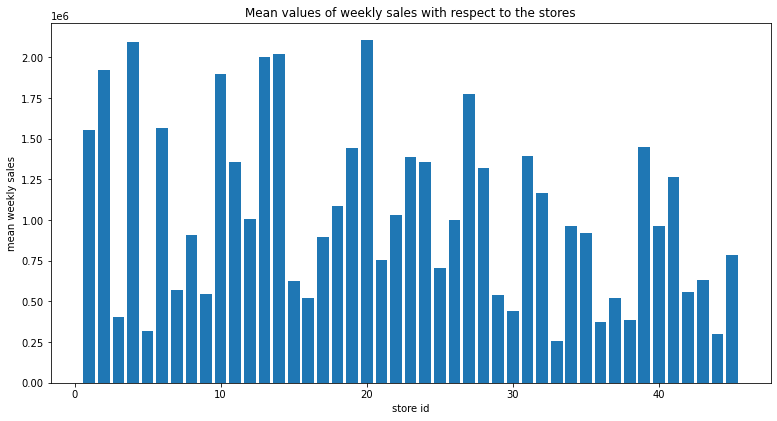

In [76]:
import matplotlib.pyplot as plt

stores = dataset['Store'].unique()
mean_sales = dataset.groupby('Store')['Weekly_Sales'].mean()
std_sales = dataset.groupby('Store')['Weekly_Sales'].std()
sales = dataset.groupby('Store')['Weekly_Sales'].sum()

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Mean values of weekly sales with respect to the stores')
ax.set_xlabel('store id')
ax.set_ylabel('mean weekly sales')
ax.bar(stores, mean_sales)
plt.show()

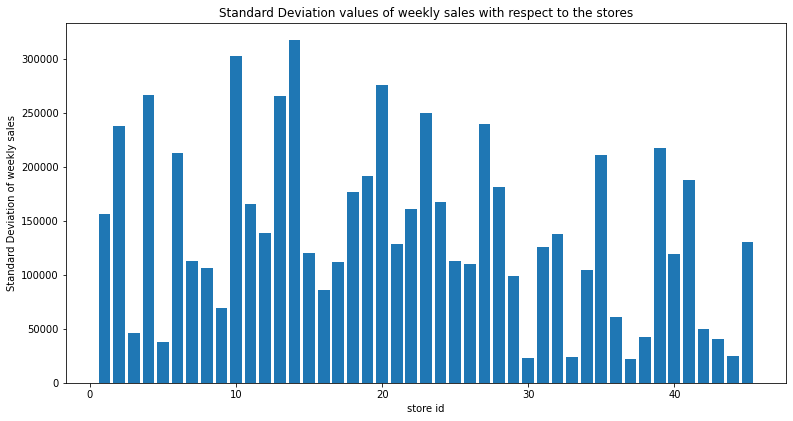

In [77]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Standard Deviation values of weekly sales with respect to the stores')
ax.set_xlabel('store id')
ax.set_ylabel('Standard Deviation of weekly sales')
ax.bar(stores, std_sales)
plt.show()

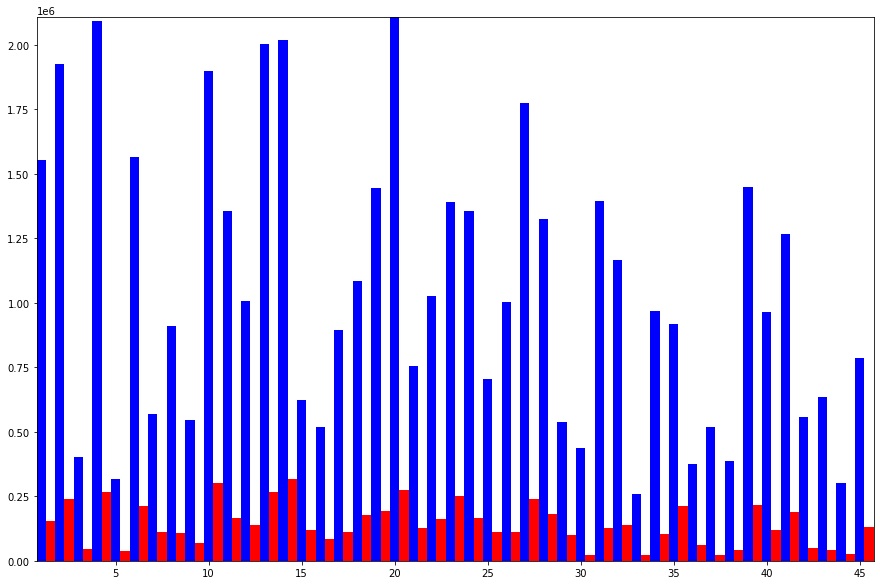

In [78]:
plt.figure(figsize=(15,10))
ax = plt.subplot(111)
ax.bar(stores, mean_sales, width=0.5, color='b', align='center')
ax.bar(stores + 0.5, std_sales, width=0.5, color='r', align='center')
ax.autoscale(tight=True)
plt.show()

On the graphs above, we can see defference between mean and standart deviation values of weekly sales with respect to the stores.

In [79]:
dataset.loc[dataset['Date'].notnull(), 'Date'] = dataset.loc[dataset['Date'].notnull(), 'Date'].astype('datetime64')
fig = px.line(dataset.loc[dataset['Date'].notnull(), :].sort_values(by = 'Date'), x='Date', y="Weekly_Sales")
fig.update_layout(xaxis = go.layout.XAxis(rangeslider = go.layout.xaxis.Rangeslider(visible = True)))
fig.show()

We can notice that sales fluctuate over time, there may even be a certain seasonality! This is why it would be useful to extract numerical characteristics from the Date column, in order to take it into account in our model.

In [80]:
from IPython.display import display
data_desc = dataset.describe(include='all', datetime_is_numeric=True) 
display(data_desc)

print("Percentage of missing values: ")
print(100*dataset.isnull().sum()/dataset.shape[0])

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 20:18:27.692307712,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-01-10 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-12 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-03-02 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-12-10 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


Percentage of missing values: 
Store           0.0
Date            0.0
Weekly_Sales    0.0
Holiday_Flag    0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
dtype: float64


In [84]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

X = dataset[dataset['Store'] == 36]
y = X.loc[:, 'Weekly_Sales']
dataset.loc[dataset['Date'].notnull(), 'Year'] = dataset.loc[dataset['Date'].notnull(), 'Date'].astype('datetime64').dt.year
dataset.loc[dataset['Date'].notnull(), 'Month'] = dataset.loc[dataset['Date'].notnull(), 'Date'].astype('datetime64').dt.month
dataset.loc[dataset['Date'].notnull(), 'Day'] = dataset.loc[dataset['Date'].notnull(), 'Date'].astype('datetime64').dt.day
X = X.drop(['Date', 'Weekly_Sales', 'Holiday_Flag',], axis=1)

X = X.values.reshape(-1,len(X.columns))
y = y.values.reshape(-1)
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=43)

poly = PolynomialFeatures(2, include_bias=False)
model = Pipeline(steps=[
    ("poly", poly), 
    ("model", linear_model.Ridge(alpha=0.00001))
])
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_pred = model.predict(X_test)


print(f'MSE: {mean_squared_error(y_pred, Y_test)}')

MSE: 200401267.67000353


Here I added an R2 regularization combined with pre-conditioned data.

In [82]:
Y = dataset.loc[:, 'Weekly_Sales']
X = dataset.loc[:,[c for c in dataset.columns if c!='Weekly_Sales']] 
X = X.values
Y = Y.tolist()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

numeric_features = [2, 3, 4, 5, 6, 7, 8, 9]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [0, 1] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [83]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
model = LinearRegression()
model.fit(X_train, Y_train) 
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9639676958503952
R2 score on test set :  0.9613309898620146


Our first model performs very well, because the R^2 is quite close to 1 on the train set AND on the test set. However, we can notice that the model is a little over-learning (R^2(test) < R^2(train)).